In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Scaling Gaussian Processes to big datasets

This notebook was made with the following version of george:

In [2]:
import george
george.__version__

'0.3.1'

One of the biggest technical challenges faced when using Gaussian Processes to model big datasets is that the computational cost naïvely scales as $\mathcal{O}(N^3)$ where $N$ is the number of points in you dataset. This cost can be prohibitive even for moderately sized datasets. There are a lot of methods for making these types of problems tractable by exploiting structure or making approximations. George comes equipped with one approximate method with controllable precision that works well with one-dimensional inputs (time series, for example). The method comes from [this paper](http://arxiv.org/abs/1403.6015) and it can help speed up many—but not all—Gaussian Process models.

To demonstrate this method, in this tutorial, we'll benchmark the two Gaussian Process "solvers" included with george. For comparison, we'll also measure the computational cost of the same operations using the popular [GPy library](https://github.com/SheffieldML/GPy) and the [new scikit-learn interface](https://github.com/scikit-learn/scikit-learn/pull/4270). Note that GPy is designed a Gaussian Process toolkit and it comes with a huge number state-of-the-art algorithms for the application of Gaussian Processes and it is not meant for efficiently computing marginalized likelihoods so the comparison isn't totally fair.

As usual, we'll start by generating a large fake dataset:

In [3]:
import numpy as np
import matplotlib.pyplot as pl

np.random.seed(1234)
x = np.sort(np.random.uniform(0, 10, 50000))
yerr = 0.1 * np.ones_like(x)
y = np.sin(x)

The standard method for computing the marginalized likelihood of this dataset under a GP model is:

In [4]:
from george import kernels
kernel = np.var(y) * kernels.ExpSquaredKernel(1.0)

gp_basic = george.GP(kernel)
gp_basic.compute(x[:100], yerr[:100])
print(gp_basic.log_likelihood(y[:100]))

133.946394912


When using only 100 data points, this computation is very fast but we could also use the approximate solver as follows:

In [5]:
gp_hodlr = george.GP(kernel, solver=george.HODLRSolver, seed=42)
gp_hodlr.compute(x[:100], yerr[:100])
print(gp_hodlr.log_likelihood(y[:100]))

133.946394912


The new scikit-learn interface is quite similar (you'll need to install a recent version of scikit-learn to execute this cell):

In [6]:
import sklearn
print("sklearn version: {0}".format(sklearn.__version__))
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

kernel_skl = np.var(y) * RBF(length_scale=1.0)
gp_skl = GaussianProcessRegressor(kernel_skl,
                                  alpha=yerr[:100]**2,
                                  optimizer=None,
                                  copy_X_train=False)
gp_skl.fit(x[:100, None], y[:100])
print(gp_skl.log_marginal_likelihood(kernel_skl.theta))

sklearn version: 0.19.1
133.946394918


To implement this same model in GPy, you would do something like (I've never been able to get the heteroscedastic regression to work in GPy):

In [7]:
import GPy

print("GPy version: {0}".format(GPy.__version__))
kernel_gpy = GPy.kern.RBF(input_dim=1, variance=np.var(y), lengthscale=1.)
gp_gpy = GPy.models.GPRegression(x[:100, None], y[:100, None], kernel_gpy)
gp_gpy['.*Gaussian_noise'] = yerr[0]**2
print(gp_gpy.log_likelihood())

GPy version: 1.8.4
133.946345613


Now that we have working implementations of this model using all of the different methods and modules, let's run a benchmark to look at the computational cost and scaling of each option. The code here doesn't matter too much but we'll compute the best-of-"K" runtime for each method where "K" depends on how long I'm willing to wait. This cell takes a few minutes to run.

In [8]:
import time

ns = np.array([50, 100, 200, 500, 1000, 5000, 10000, 50000], dtype=int)
t_basic = np.nan + np.zeros(len(ns))
t_hodlr = np.nan + np.zeros(len(ns))
t_gpy = np.nan + np.zeros(len(ns))
t_skl = np.nan + np.zeros(len(ns))
for i, n in enumerate(ns):
    # Time the HODLR solver.
    best = np.inf
    for _ in range(100000 // n):
        strt = time.time()
        gp_hodlr.compute(x[:n], yerr[:n])
        gp_hodlr.log_likelihood(y[:n])
        dt = time.time() - strt
        if dt < best:
            best = dt
    t_hodlr[i] = best
    
    # Time the basic solver.
    best = np.inf
    for _ in range(10000 // n):
        strt = time.time()
        gp_basic.compute(x[:n], yerr[:n])
        gp_basic.log_likelihood(y[:n])
        dt = time.time() - strt
        if dt < best:
            best = dt
    t_basic[i] = best
    
    # Compare to the proposed scikit-learn interface.
    best = np.inf
    if n <= 10000:
        gp_skl = GaussianProcessRegressor(kernel_skl,
                                          alpha=yerr[:n]**2,
                                          optimizer=None,
                                          copy_X_train=False)
        gp_skl.fit(x[:n, None], y[:n])
        for _ in range(10000 // n):
            strt = time.time()
            gp_skl.log_marginal_likelihood(kernel_skl.theta)
            dt = time.time() - strt
            if dt < best:
                best = dt
    t_skl[i] = best

    # Compare to GPy.
    best = np.inf
    for _ in range(5000 // n):
        kernel_gpy = GPy.kern.RBF(input_dim=1, variance=np.var(y), lengthscale=1.)
        strt = time.time()
        gp_gpy = GPy.models.GPRegression(x[:n, None], y[:n, None], kernel_gpy)
        gp_gpy['.*Gaussian_noise'] = yerr[0]**2
        gp_gpy.log_likelihood()
        dt = time.time() - strt
        if dt < best:
            best = dt
    t_gpy[i] = best

Finally, here are the results of the benchmark plotted on a logarithmic scale:

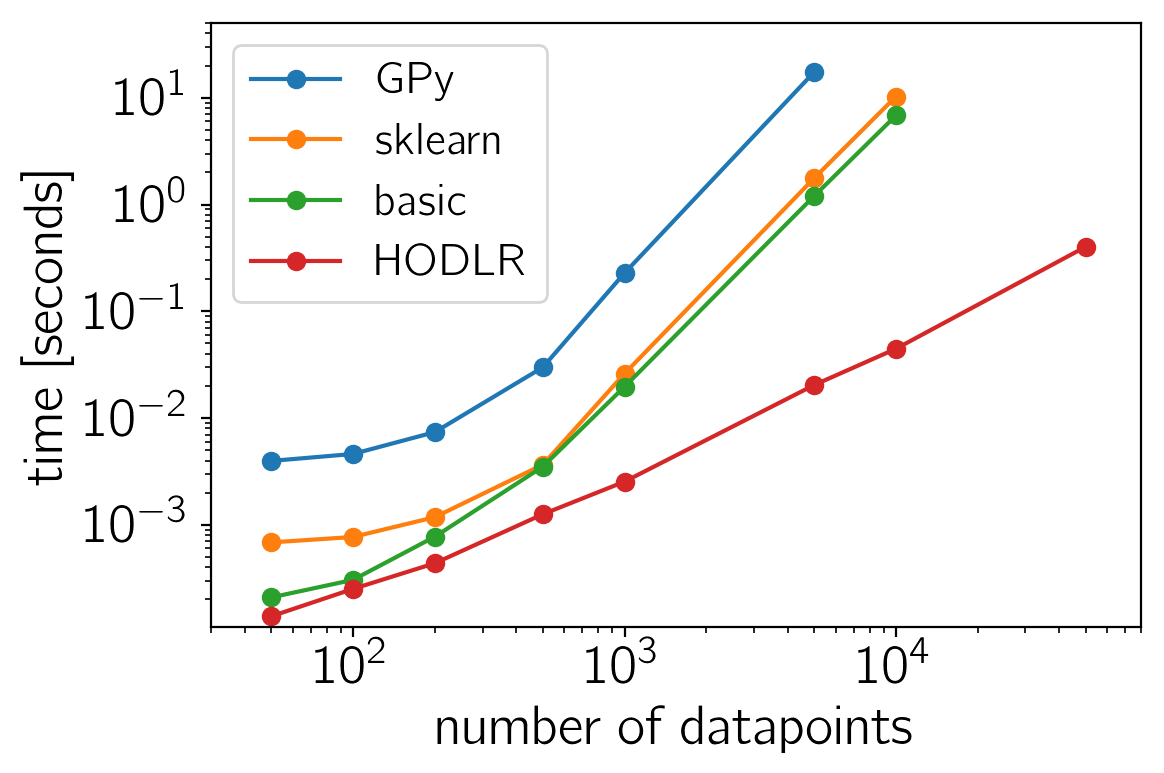

In [9]:
pl.loglog(ns, t_gpy, "-o", label="GPy")
pl.loglog(ns, t_skl, "-o", label="sklearn")
pl.loglog(ns, t_basic, "-o", label="basic")
pl.loglog(ns, t_hodlr, "-o", label="HODLR")
pl.xlim(30, 80000)
pl.ylim(1.1e-4, 50.)
pl.xlabel("number of datapoints")
pl.ylabel("time [seconds]")
pl.legend(loc=2, fontsize=16);

The sklearn and basic solver perform similarly with george being consistently slightly faster. This is not surprising because they both use LAPACK (via numpy/scipy) to naïvely compute the likelihood. GPy is consistently slower (probably because of Python overheads) even for small datasets but, like I mentioned previously, this wasn't really what GPy was designed to do and it comes with a lot of other features. For large datasets ($N \gtrsim 1000$), the `HODLRSolver` really shines. In practice, this gain is less significant for multidimensional inputs and some other kernels but for reasonably well-behaved time-series models, it might solve all of your problems!